# 

In [137]:
import pandas as pd
import matplotlib.pyplot as plt

In [138]:
def load_and_preprocess_apys(filepath):
    """Load and preprocess the APYs DataFrame."""
    apys_df = pd.read_csv(filepath)
    apys_df.drop(labels=['APY_REWARD', 'APY_BASE', 'TVL'], axis=1, inplace=True)
    apys_df["DATE"] = pd.to_datetime(apys_df["DATE"]).dt.date
    return apys_df

def path_dict_to_df(type):
    """Reads all files in the given dictionary and concatenates them into a single DataFrame."""
    dict_path = {
        'aave': 'apys_aave_v2_USDC.csv',
        'compound': 'apys_compound_USDC.csv',
        'uniswap': 'apys_uniswap_v3-USDC-USDT.csv',
        'balancer': 'apys_balancer_v3_USDC.csv',
    }
    df = load_and_preprocess_apys(dict_path[type])
    return df



def aplication_cdi(amount, date_month):
    """
    Calculates the return based on the CDI for the month of the given date.
    If the exact month is not available, uses the most recent month before the given date.

    Parameters:
    amount (float): The initial investment value.
    date_month (np.datetime64): The date to determine the month and year for CDI calculation.

    Returns:
    float: The calculated return based on the CDI for the month.
    """
    df_cdi = DataFrameLoader.load_and_preprocess_cdi()
    if not isinstance(date_month, pd.Timestamp):
        date_month = pd.to_datetime(date_month)
        
    # Check for an exact match first
    df_exact = df_cdi[df_cdi['date_month'] == date_month]
    if not df_exact.empty:
        cdi = float(df_exact['cdi'].iloc[0])
    else:
        # Find the most recent month before the given date
        df_before = df_cdi[df_cdi['date_month'] < date_month]
        if df_before.empty:
            raise ValueError("No CDI data available for the given date or before.")
        
        df_before_sorted = df_before.sort_values('date_month')
        cdi = float(df_before_sorted.iloc[-1]['cdi'])
        
    return amount * (1 + cdi*0.85)


def load_and_preprocess_grupo(filepath, number_elements=None):
    if number_elements:
        df = pd.read_csv(filepath, nrows=number_elements, low_memory=False)
    else:
        df = pd.read_csv(filepath, low_memory=False)

    df.drop(columns=['id_quotas_santander', 'cd_grupo', 'cd_cota', 'cd_produto', 'nm_situ_entrega_bem', 'created_at', 'is_processed', 'cd_versao_cota', 'cd_tipo_pessoa', 'pz_comercializacao', 'vl_lance_proprio'], inplace=True)
    rename_map = {
        "pc_fc_pago": "FC_paid_%",
        "pc_fundo_reserva": "FR_%",
        "pc_fr_pago": "FR_paid_%",
        "pc_tx_adm": "TX_adm_%",
        "pc_tx_pago": "TX_paid_%",
        "pc_seguro": "Seguro_%",
        "nr_contrato": "id",
        "vl_bem_atual": "vl_bem",
        "pz_restante_grupo": "remaining_period",
        "qt_parcela_a_pagar": "parc_to_pay",
        "pz_contratado": "contracted_period",
        "qt_parcela_paga": "parc_paid",
        "pz_decorrido_grupo": "T_decorrido",
        "dt_entrega_bem": "dt_entrega",
        "vl_lance_embutido": "embedded_bid_vl",
        "vl_bem_corrigido": "bem_corrig_vl",
        "vl_total_contrato": "total_contract_vl",
        "vl_lance_proprio": "own_bid_vl",
        "qt_pc_atraso": "qt_parc_atraso",
        "qt_pc_lance": "qt_parc_lance",
    }
    df = df.rename(columns=rename_map)
    
    df['id'] = df['id'].astype(int)
    date_columns = ['dt_canc', 'dt_contemplacao', 'data_info', 'dt_entrega']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col]).dt.date
    # Ensure 'data_info' is in datetime format
    df['data_info'] = pd.to_datetime(df['data_info'])

    # Group by 'id' and get the row with the most recent 'data_info' for each group
    df_most_recent = df.loc[df.groupby('id')['data_info'].idxmax()]

    return df_most_recent

def get_apy_by_month(target_date, df):
    """
    Returns the average APY for the month of the given date if it exists in the dataset.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'DATE' and 'APY' columns.
    target_date (np.datetime64): The date to search for (used to determine the month and year).

    Returns:
    float or None: The average APY value for the month if data exists, otherwise None.
    """
    df["DATE"] = pd.to_datetime(df["DATE"])
    target_year = pd.to_datetime(target_date).year
    target_month = pd.to_datetime(target_date).month

    monthly_data = df[(df["DATE"].dt.year == target_year) & (df["DATE"].dt.month == target_month)]
    return monthly_data["APY"].mean() if not monthly_data.empty else df["APY"].loc[0], monthly_data["GAS_PRICE_MED"].mean()

def calcular_rentabilidade_mes(valor, data, apys_df=None, type='circulana'):
    """
    Calculates the return based on the average APY for the month of the given date.

    Parameters:
    valor (float): The initial investment value.
    data (np.datetime64): The date to determine the month and year for APY calculation.
    type (str): The type of calculation (default is 'circulana').
    apys_df (pd.DataFrame): DataFrame containing APY data.

    Returns:
    float: The calculated return based on the average APY for the month.
    """
    if type == 'circulana':
        apy, gas_fee = get_apy_by_month(data, apys_df)
        
        if apy is not None:
            apym = (1 + apy / 100) ** (1/12) - 1
            return valor * (1 + apym) - gas_fee
        else:
            return valor * (1 + 0.0007) - gas_fee
    else:
        return valor

def find_corrected_values(given_value, last_known_year, target_year):
    """
    Find the corrected value for a target year based on a given value in the last known year,
    proportionally to the FIPE data.
    
    Parameters:
    - given_value: The known value for last_known_year
    - last_known_year: The year of the given value
    - target_year: The year for which we want to find the corrected value
    
    Returns:
    - The corrected value for the target year
    """
    # Load the correction dataframe
    loader = DataFrameLoader()
    df_correction = loader.load_and_preprocess_correction('FIPE-GRUPO-655-FIPE.csv')
    
    # Identify the necessary columns
    last_known_col = f"valor_{last_known_year}"
    target_col = f"valor_{target_year}"
    
    if last_known_col not in df_correction.columns or target_col not in df_correction.columns:
        return given_value  # Return original value if columns don't exist
    
    # Iterate through the dataframe to find a proportional match
    for _, row in df_correction.iterrows():
        if pd.isna(row[last_known_col]) or pd.isna(row[target_col]):
            continue
        
        try:
            # Find proportional factor from last known year to target year
            proportion_factor = row[target_col] / row[last_known_col]
            return given_value * proportion_factor
        except (ZeroDivisionError, ValueError):
            continue
    
    return given_value

class DataFrameLoader:
    _instance = None

    def __new__(cls, *args, **kwargs):
        if not cls._instance:
            cls._instance = super(DataFrameLoader, cls).__new__(cls, *args, **kwargs)
        return cls._instance

    def __init__(self):
        self.df_usd = None
        self.df_correction = None

    def load_and_preprocess_usd_brl(self, filepath):
        if self.df_usd is None:
            self.df_usd = pd.read_csv(filepath)
            self.df_usd.drop(columns=['Último', 'Máxima', 'Mínima', 'Var%', 'Vol.'], inplace=True)
            self.df_usd.columns = ['date', 'usd']
            self.df_usd['date'] = pd.to_datetime(self.df_usd['date'], format='%d-%m-%Y', dayfirst=True)
            self.df_usd['usd'] = self.df_usd['usd'].str.replace(',', '.').astype(float)
            self.df_usd['usd'] = self.df_usd['usd'].apply(lambda x: x / 10)
        return self.df_usd

    def load_and_preprocess_correction(self, filepath):
        if self.df_correction is None:
            self.df_correction = pd.read_csv(filepath)
            for year in range(2020, 2026):
                self.df_correction[f'valor_{year}'] = (
                    self.df_correction[f'valor_{year}']
                    .astype(str)
                    .str.replace('.', '', regex=False)
                    .str.replace(',', '.', regex=False)
                    .astype(float)
                )
            self.df_correction['inicio_grupo'] = pd.to_datetime(self.df_correction['inicio_grupo'])
            self.df_correction['termino_grupo'] = pd.to_datetime(self.df_correction['termino_grupo'])
        return self.df_correction
    def load_and_preprocess_cdi(filepath = 'cdi.csv'):
        """Load and preprocess the CDI DataFrame."""
        df_cdi = pd.read_csv(filepath)
        df_cdi.rename(columns={'Data': 'date_month', 'Taxa de juros - CDI / Over - acumulada no mês': 'cdi'}, inplace=True)
        df_cdi['cdi'] = df_cdi['cdi'].str.replace(',', '.').astype(float)/100
        df_cdi['date_month'] = pd.to_datetime(df_cdi['date_month'], format='%Y-%m')
        df_cdi = df_cdi[df_cdi['date_month'] >= pd.Timestamp('2020-01')].reset_index(drop=True)
        return df_cdi

def correct_real(initial_date, initial_amount=1.0, final_date=None, correction_type='daily'):
    """
    Calculates the corrected value of an initial investment in BRL over time based on USD variation.

    Parameters:
    - initial_date (str or datetime): The start date of the investment.
    - initial_amount (float): The initial amount in BRL.
    - final_date (str or datetime, optional): The end date of the investment.
    - correction_type (str): 'daily' for daily correction, 'monthly' for monthly correction (same day each month).

    Returns:
    - Final corrected value (float)
    - Final date reached (datetime)
    """
    loader = DataFrameLoader()
    df_usd = loader.load_and_preprocess_usd_brl('USD_BRL.csv')
    # Convert input dates to datetime
    initial_date = pd.to_datetime(initial_date, format='%d-%m-%Y')
    if final_date:
        final_date = pd.to_datetime(final_date, format='%d-%m-%Y')

    # Ensure we start from the exact given date
    df_filtered = df_usd[df_usd['date'] >= initial_date].copy()
    
    if df_filtered.empty:
        raise ValueError("No data available for the given date. Choose an earlier date.")

    # Start with initial amount
    amount = initial_amount

    if correction_type == 'daily':
        if final_date:
            df_final = df_usd[df_usd['date'] <= final_date].copy()
            if df_final.empty:
                raise ValueError("No data available for the given final date. Choose a later date.")
            final_usd = df_final.iloc[-1]['usd']
        else:
            final_usd = df_filtered.iloc[-1]['usd']
        current_amount = amount * (final_usd / df_filtered.iloc[0]['usd'])

    elif correction_type == 'monthly':
        if final_date:
            final_year = final_date.year
            final_month = final_date.month
            df_final = df_usd[(df_usd['date'].dt.year == final_year) & (df_usd['date'].dt.month == final_month)]
            if df_final.empty:
                raise ValueError("No data available for the given final date. Choose a later date.")
            final_usd = df_final['usd'].mean()
        else:
            final_usd = df_filtered['usd'].mean()
        current_amount = amount * (final_usd / df_filtered.iloc[0]['usd'])

    return round(current_amount, 4)

def convert_currency(date, amount, to_currency='usd'):
    """
    Converts an amount between BRL and USD based on the exchange rate of a given date.

    Parameters:
    - date (str or datetime): The date for the conversion.
    - amount (float): The amount to be converted.
    - to_currency (str): 'usd' to convert BRL → USD, 'brl' to convert USD → BRL.

    Returns:
    - Converted amount (float).
    """
    loader = DataFrameLoader()
    df_usd = loader.load_and_preprocess_usd_brl('usd-variation.csv')

    date = pd.to_datetime(date, format='%d-%m-%Y')

    # Find the closest available date with exchange data
    df_filtered = df_usd[df_usd['date'] <= date]
    if df_filtered.empty:
        raise ValueError("No exchange rate data available for the given date or earlier.")

    exchange_rate = df_filtered.iloc[-1]['usd']  # Latest available rate before or on the given date

    if to_currency == 'usd':
        return round(amount / exchange_rate, 4)  # BRL → USD
    elif to_currency == 'brl':
        return round(amount * exchange_rate, 4)  # USD → BRL
    else:
        raise ValueError("Invalid currency conversion type. Use 'usd' or 'brl'.")

In [139]:
import numpy as np
import pandas as pd
import warnings

def expandir_cotas(df, colateral=0.4, apys_df=None, compounded=False, tx_adm_circulana=None):
    """Expand the DataFrame for each month."""
    expanded_rows_consorcio = []
    expanded_rows_circulana = []
    grouped = df.groupby('id')

    for cota_id, group in grouped:
        last_row = group.iloc[-1]
        vl_bem = last_row["vl_bem"]
        TX_adm_percent = last_row["TX_adm_%"]
        start_date = pd.to_datetime(last_row["dt_venda"])
        contracted_period = min(last_row["contracted_period"], (pd.Timestamp.today() - start_date).days // 30)
        embedded_bid_vl = last_row["embedded_bid_vl"]
        vl_devolver = last_row["vl_devolver"]
        seguro_percent = last_row["Seguro_%"]
        if seguro_percent is None or np.isnan(seguro_percent):
            seguro_percent = 0.0
        dt_cancel = pd.to_datetime(last_row["dt_canc"])
        year = pd.to_datetime(start_date).year
        dt_contemplacao = pd.to_datetime(last_row["dt_contemplacao"])

        FC_already_paid = 0.0
        TX_already_paid = 0.0
        FR_already_paid = 0.0
        TX_already_paid_circulana = 0.0
        rentabilidade_colateral = 0.0
        rentabilidade_colateral_real = 0.0
        rentabilidade_colateral_bem = 0.0
        rentabilidade_bem_contemplacao_real = 0.0
        bem_contemplacao = None
        profits_colateral = 0.0
        profits_bem = 0.0
        profits_colateral_dolar = 0.0
        profits_bem_dolar = 0.0
        consorcio_cdi = 0.0
        profits_consorcio_cdi = 0.0
        first_month = True
        bem_contemplacao_dolar_show = 0.0
        total_seguro = 0.0

        end_date = min(filter(pd.notna, [
            pd.Timestamp(dt_cancel) if pd.notna(dt_cancel) else None,
            start_date + pd.DateOffset(months=contracted_period),
            pd.Timestamp.today()
        ]))

        months = pd.date_range(start=start_date, end=end_date, freq='MS')
        max_vl_bem_corrigido = vl_bem

        for month in months:
            canceled = pd.notna(dt_cancel) and month >= pd.Timestamp(dt_cancel)
            if canceled:
                continue
            contemplated = pd.notna(dt_contemplacao) and month >= pd.Timestamp(dt_contemplacao)

            vl_bem_corrigido = find_corrected_values(vl_bem, year, month.year)
            vl_bem_corrigido = max(vl_bem_corrigido, max_vl_bem_corrigido)
            max_vl_bem_corrigido = vl_bem_corrigido
            if not canceled:
                fc_monthly = max_vl_bem_corrigido / contracted_period
                tx_monthly = (TX_adm_percent / 100) * max_vl_bem_corrigido / contracted_period
                fr_monthly = max_vl_bem_corrigido * (last_row["FR_%"] / 100) / contracted_period
            else:
                fc_monthly = 0.0
                tx_monthly = 0.0
                fr_monthly = 0.0
                tx_adm_circulana = 0.0
                seguro_percent = 0.0
            FC_already_paid += fc_monthly
            TX_already_paid += tx_monthly
            FR_already_paid += fr_monthly
            if tx_adm_circulana is not None:
                try:
                    tx_adm_circulana_value = tx_adm_circulana * max_vl_bem_corrigido / contracted_period
                    if np.isinf(tx_adm_circulana_value) or np.isnan(tx_adm_circulana_value):
                        raise OverflowError(f"Overflow detected: tx_adm_circulana={tx_adm_circulana}, vl_bem_corrigido={max_vl_bem_corrigido}, contracted_period={contracted_period}")
                except OverflowError as e:
                    warnings.warn(str(e))
                    tx_adm_circulana_value = np.nan
            else:
                tx_adm_circulana = TX_adm_percent / 100
                tx_adm_circulana_value = tx_adm_circulana * max_vl_bem_corrigido / contracted_period
            TX_already_paid_circulana += tx_adm_circulana_value
            seguro_monthly = (float(seguro_percent) / 100) * max_vl_bem_corrigido / contracted_period
            total_seguro += seguro_monthly

            if contemplated:
                if not bem_contemplacao:
                    bem_contemplacao = max_vl_bem_corrigido
                    bem_contemplacao_dolar = convert_currency(date=month, amount=bem_contemplacao)

                valor_colateral = colateral * bem_contemplacao_dolar
                if consorcio_cdi == 0.0:
                    consorcio_cdi = bem_contemplacao
                else:
                    consorcio_cdi = aplication_cdi(consorcio_cdi, month)
                profits_consorcio_cdi += consorcio_cdi - bem_contemplacao

                base_valor_colateral = valor_colateral if (not compounded or first_month) else rentabilidade_colateral
                rentabilidade_colateral = calcular_rentabilidade_mes(valor=base_valor_colateral, data=month, apys_df=apys_df)
                profits_colateral_dolar += rentabilidade_colateral - valor_colateral

                base_valor_bem = bem_contemplacao_dolar if (not compounded or first_month) else rentabilidade_colateral_bem
                rentabilidade_colateral_bem = calcular_rentabilidade_mes(valor=base_valor_bem, data=month, apys_df=apys_df)
                profits_bem_dolar += rentabilidade_colateral_bem - bem_contemplacao_dolar

                rentabilidade_colateral_real = convert_currency(date=month, amount=rentabilidade_colateral, to_currency='brl')
                rentabilidade_bem_contemplacao_real = convert_currency(date=month, amount=rentabilidade_colateral_bem, to_currency='brl')
                profits_bem = convert_currency(date=month, amount=profits_bem_dolar, to_currency='brl')
                profits_colateral = convert_currency(date=month, amount=profits_colateral_dolar, to_currency='brl')
                bem_contemplacao_dolar_show = convert_currency(date=month, amount=bem_contemplacao_dolar+profits_bem_dolar, to_currency='brl')
                if not first_month:
                    first_month = False

            common_values = {
                "id": cota_id,
                "month": month,
                "canceled": canceled,
                "contemplated": contemplated,
                "vl_bem": max_vl_bem_corrigido if not bem_contemplacao else bem_contemplacao,
                "vl_devolver": vl_devolver if canceled else 0.0,
                "contracted_period": contracted_period,
                "embedded_bid_vl": embedded_bid_vl,
                "FC_paid": fc_monthly if not canceled else 0.0,
            }

            consorcio_specific = {
                "TX_adm_paid": TX_already_paid,
                "FC_paid_%": min(FC_already_paid / vl_bem, 1.0),
                "FC_paid_monthly": fc_monthly,
                "TX_paid_%": min(TX_already_paid / ((TX_adm_percent / 100) * vl_bem), 1.0),
                "FR_paid": FR_already_paid,
                "FR_paid_%": min(FR_already_paid / (last_row["FR_%"] / 100 * vl_bem), 1.0),
                "FR_paid_monthly": fr_monthly,
                "seguro_paid": seguro_monthly,
                "Seguro_%": seguro_percent,
                "TX_adm_%": TX_adm_percent / 100,
                "consorcio_w_profits": consorcio_cdi,
                "profits_consorcio": profits_consorcio_cdi,
                "TX_adm_monthly": tx_monthly,
                "seguro_monthly": seguro_monthly,
            }
            consorcio_dict = {**common_values, **consorcio_specific}
            expanded_rows_consorcio.append(consorcio_dict)

            circulana_specific = {
                "FC_paid_%": min(FC_already_paid / vl_bem, 1.0),
                "TX_paid_%": min(TX_already_paid_circulana / (tx_adm_circulana * vl_bem), 1.0),
                "TX_adm_%": tx_adm_circulana,
                "colateral_w_profits": rentabilidade_colateral_real,
                "bem_contemplacao_w_profits": rentabilidade_bem_contemplacao_real,
                "colateral_initial": colateral * bem_contemplacao if contemplated else 0.0,
                "TX_adm_paid": TX_already_paid_circulana if not canceled else 0.0,
                "TX_adm_monthly": tx_adm_circulana_value,
                "profits_colateral": profits_colateral,
                "profits_bem": profits_bem,
                "bem_contemplacao_dolar": bem_contemplacao_dolar_show,
                "bem_contemplacao_dolar_colateral": bem_contemplacao_dolar_show * colateral,
            }
            circulana_dict = {**common_values, **circulana_specific}
            expanded_rows_circulana.append(circulana_dict)

    df_expanded_consorcio = pd.DataFrame(expanded_rows_consorcio)
    df_expanded_circulana = pd.DataFrame(expanded_rows_circulana)
    return df_expanded_consorcio, df_expanded_circulana

# Parametros

In [140]:
# Input Parameters
## places of interest: aave, compound, uniswap, balancer
rentability_type = "circulana"
place_of_interest = "aave"
percentual_colateral = 0.4
compounded = False

In [141]:
# Load Data
apys_df = path_dict_to_df(place_of_interest)
df_grupo = load_and_preprocess_grupo('santander_cotas_pre_grupo_md_cota655_202502211443.csv')

# Process Data
df_expanded_consorcio, df_expanded_circulana = expandir_cotas(
    df_grupo,
    colateral=percentual_colateral, 
    apys_df=apys_df,
    tx_adm_circulana=0.05
)

In [145]:
# Save the expanded DataFrames to CSV files
df_expanded_consorcio.to_csv('df_expanded_consorcio.csv', index=False)
df_expanded_circulana.to_csv('df_expanded_circulana.csv', index=False)

# Save the expanded DataFrames to pickle files to preserve datatypes
df_expanded_consorcio.to_pickle('df_expanded_consorcio.pkl')
df_expanded_circulana.to_pickle('df_expanded_circulana.pkl')

In [146]:
import pandas as pd

# Load the DataFrame from a pickle file
df_expanded_consorcio = pd.read_pickle('df_expanded_consorcio.pkl')
df_expanded_circulana = pd.read_pickle('df_expanded_circulana.pkl')

# Display the DataFrame
print(df_expanded_consorcio.head())
print(df_expanded_circulana.head())

       id      month  canceled  contemplated   vl_bem  vl_devolver  \
0  257325 2023-07-01     False         False  37263.6          0.0   
1  257325 2023-08-01     False         False  37263.6          0.0   
2  257325 2023-09-01     False         False  37263.6          0.0   
3  257325 2023-10-01     False         False  37263.6          0.0   
4  257325 2023-11-01     False         False  37263.6          0.0   

   contracted_period  embedded_bid_vl      FC_paid  TX_adm_paid  ...  \
0                 21              NaN  1774.457143     211.1604  ...   
1                 21              NaN  1774.457143     422.3208  ...   
2                 21              NaN  1774.457143     633.4812  ...   
3                 21              NaN  1774.457143     844.6416  ...   
4                 21              NaN  1774.457143    1055.8020  ...   

   FR_paid_%  FR_paid_monthly  seguro_paid  Seguro_%  TX_adm_%  \
0   0.047619           62.106          0.0       0.0     0.119   
1   0.095238  

In [147]:
df_expanded_consorcio[df_expanded_consorcio["id"] == 270335].head(10)

,id,month,canceled,contemplated,vl_bem,vl_devolver,contracted_period,embedded_bid_vl,FC_paid,TX_adm_paid,...,FR_paid_%,FR_paid_monthly,seguro_paid,Seguro_%,TX_adm_%,consorcio_w_profits,profits_consorcio,TX_adm_monthly,seguro_monthly,total_paid
1283,270335,2023-12-01,False,False,38715.600000,0.0,16,12108.34,2419.725000,169.380750,...,0.062500,84.690375,0.0,0.0,0.07,0.000000,0.000000,169.380750,0.0,2673.796125
1284,270335,2024-01-01,False,False,41247.791601,0.0,16,12108.34,2577.986975,349.839838,...,0.129088,90.229544,0.0,0.0,0.07,0.000000,0.000000,180.459088,0.0,2933.365982
1285,270335,2024-02-01,False,False,41247.791601,0.0,16,12108.34,2577.986975,530.298927,...,0.195676,90.229544,0.0,0.0,0.07,0.000000,0.000000,180.459088,0.0,3023.595527
1286,270335,2024-03-01,False,True,41247.791601,0.0,16,12108.34,2577.986975,710.758015,...,0.262263,90.229544,0.0,0.0,0.07,41247.791601,0.000000,180.459088,0.0,3113.825071
1287,270335,2024-04-01,False,True,41247.791601,0.0,16,12108.34,2577.986975,891.217103,...,0.328851,90.229544,0.0,0.0,0.07,41559.831144,312.039543,180.459088,0.0,3204.054615
1288,270335,2024-05-01,False,True,41247.791601,0.0,16,12108.34,2577.986975,1071.676191,...,0.395439,90.229544,0.0,0.0,0.07,41853.035753,917.283696,180.459088,0.0,3294.284159
1289,270335,2024-06-01,False,True,41247.791601,0.0,16,12108.34,2577.986975,1252.135280,...,0.462027,90.229544,0.0,0.0,0.07,42134.078888,1803.570983,180.459088,0.0,3384.513703
1290,270335,2024-07-01,False,True,41247.791601,0.0,16,12108.34,2577.986975,1432.594368,...,0.528615,90.229544,0.0,0.0,0.07,42459.985988,3015.765370,180.459088,0.0,3474.743247
1291,270335,2024-08-01,False,True,41247.791601,0.0,16,12108.34,2577.986975,1613.053456,...,0.595202,90.229544,0.0,0.0,0.07,42773.977585,4541.951354,180.459088,0.0,3564.972791
1292,270335,2024-09-01,False,True,41247.791601,0.0,16,12108.34,2577.986975,1793.512544,...,0.661790,90.229544,0.0,0.0,0.07,43079.383785,6373.543538,180.459088,0.0,3655.202335


In [148]:
df_grupo[df_grupo["id"] == 270335]

,id,vl_devolver,vl_bem,FC_paid_%,dt_canc,dt_venda,remaining_period,parc_to_pay,FR_paid_%,TX_adm_%,...,dt_contemplacao,embedded_bid_vl,bem_corrig_vl,total_contract_vl,vl_bem_entregue,vl_bem_a_entregar,Seguro_%,qt_parc_atraso,qt_parc_lance,month_sold
31306,270335,0.0,38715.6,50.954,NaT,2023-11-03,23,24,1.8802,7.0,...,2024-02-06,12108.34,39056.84,42780.74,12108.34,26948.5,0.0,0.0,11.0,2023-11


In [149]:
df_grupo[df_grupo["id"] == 270335]['data_info']

31306   2024-04-09
Name: data_info, dtype: datetime64[ns]

In [150]:
loader = DataFrameLoader()
df_correction = loader.load_and_preprocess_correction('FIPE-GRUPO-655-FIPE.csv')
df_correction

,bem_inicial,bem_atual,percentual_inicial,percentual_final,inicio_grupo,termino_grupo,valor_2020,valor_2021,valor_2022,valor_2023,valor_2024,valor_2025
0,20% VOYAGE 1.6 MSI,22% POLO TRACK 1.0 MPI,"20,00%","22,00%",2020-05-19,2026-05-19,48641.0,61770.0,72304.0,73603.0,78417.0,89373.0
1,20% VOYAGE 1.6 MSI,22% POLO TRACK 1.0 MPI,"20,00%","22,00%",2020-05-19,2026-05-19,48641.0,61770.0,72304.0,73603.0,78417.0,89373.0
2,20% VOYAGE 1.0 MANUAL 4P,22% Polo Track 1.0 MPI Manual,"20,00%","22,00%",2020-05-19,2026-05-19,44709.0,55232.0,64119.0,73603.0,78417.0,89373.0
3,20% VOYAGE 1.6 MSI,22% POLO TRACK 1.0 MPI - PLANO FLEX,"20,00%","22,00%",2020-05-19,2026-05-19,48641.0,61770.0,72304.0,73603.0,78417.0,89373.0
4,25% YARIS HATCHBACK XL CVT,25% YARIS HATCHBACK XL CVT,"25,00%","25,00%",2020-05-19,2026-05-19,61568.0,71377.0,88721.0,88624.0,88854.0,106712.0
5,25% YARIS XL CVT,25% YARIS XL CVT,"25,00%","25,00%",2020-05-19,2026-05-19,61568.0,71377.0,88721.0,88624.0,88854.0,106712.0
6,25% YARIS XL CVT,25% YARIS XL CVT,"25,00%","25,00%",2020-05-19,2026-05-19,61568.0,71377.0,88721.0,88624.0,88854.0,106712.0
7,25% YARIS XL CVT - PLANO FLEX,25% YARIS XL CVT - PLANO FLEX,"25,00%","25,00%",2020-05-19,2026-05-19,61568.0,71377.0,88721.0,88624.0,88854.0,106712.0
8,40% VOYAGE 1.6 MSI,44% POLO TRACK 1.0 MPI,"40,00%","44,00%",2020-05-19,2026-05-19,48641.0,61770.0,72304.0,73603.0,78417.0,89373.0
9,40% VOYAGE 1.6 MSI,44% POLO TRACK 1.0 MPI - PLANO FLEX,"40,00%","44,00%",2020-05-19,2026-05-19,48641.0,61770.0,72304.0,73603.0,78417.0,89373.0


In [151]:
38715.6/.44

87990.0

In [152]:
61770/48641, 55232/44709

(1.2699163257334347, 1.2353664810217182)

In [153]:
# Filter quotas with TX_adm_% of 13.5 and 7, started in 2020, and were contemplated at some point
filtered_best_case = df_grupo[
    (df_grupo['TX_adm_%'] > 15.0) &
    (df_grupo['dt_venda'].dt.year == 2020) &
    (df_grupo['dt_contemplacao'].notna())
]
filtered_worst_case = df_grupo[
    (df_grupo['TX_adm_%'] < 10.0) &
    (df_grupo['dt_venda'].dt.year == 2020) &
    (df_grupo['dt_contemplacao'].notna())
]

# Select one quota with 13.5 of TX_adm_% and another with 7
quota_high = filtered_best_case.iloc[0]
quota_low = filtered_worst_case.iloc[0]
(quota_high['id'], quota_low['id'])

(np.int64(30506940), np.int64(30438293))

In [154]:
df_grupo[df_grupo['id'] == 30506940]

,id,vl_devolver,vl_bem,FC_paid_%,dt_canc,dt_venda,remaining_period,parc_to_pay,FR_paid_%,TX_adm_%,...,dt_contemplacao,embedded_bid_vl,bem_corrig_vl,total_contract_vl,vl_bem_entregue,vl_bem_a_entregar,Seguro_%,qt_parc_atraso,qt_parc_lance,month_sold
7268,30506940,0.0,27222.5,79.0695,NaT,2020-07-23,15,15,3.0383,16.0,...,2023-06-02,4293.22,27222.5,32530.89,4293.22,23294.2,0.0,1.0,18.0,2020-07


# Gráficos

Total FC: R$ 86,240,384.40
Total FR: R$ 42,547,157.81
Total Adm Taxes: R$ 153,765,333.11
### Quota 257325 Details
        id      month  canceled  contemplated        vl_bem  vl_devolver  \
0   257325 2023-07-01     False         False  37263.600000          0.0   
1   257325 2023-08-01     False         False  37263.600000          0.0   
2   257325 2023-09-01     False         False  37263.600000          0.0   
3   257325 2023-10-01     False         False  37263.600000          0.0   
4   257325 2023-11-01     False         False  37263.600000          0.0   
5   257325 2023-12-01     False         False  37263.600000          0.0   
6   257325 2024-01-01     False         False  39700.823624          0.0   
7   257325 2024-02-01     False         False  39700.823624          0.0   
8   257325 2024-03-01     False         False  39700.823624          0.0   
9   257325 2024-04-01     False         False  39700.823624          0.0   
10  257325 2024-05-01     False         False  397

<Figure size 1400x800 with 0 Axes>

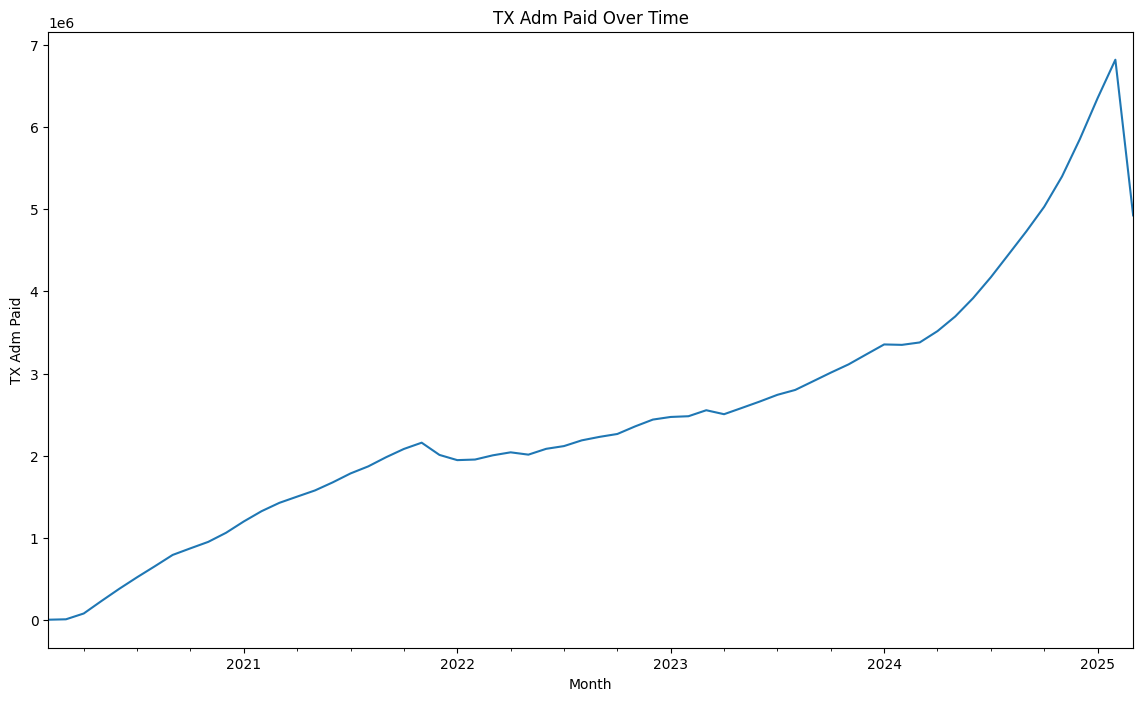

O total da taxa de adm arrecadado no grupo todo foi: R$ 153,765,333.11
Tem 2886 quotas canceladas no grupo
Tem 4380 quotas no grupo


/var/folders/nd/0cfyb2fn46s7tqfdlzncgshm0000gp/T/ipykernel_3587/2969981.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_canceled['dt_canc'] = pd.to_datetime(df_canceled['dt_canc'])
/var/folders/nd/0cfyb2fn46s7tqfdlzncgshm0000gp/T/ipykernel_3587/2969981.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_canceled['month'] = df_canceled['dt_canc'].dt.to_period('M')


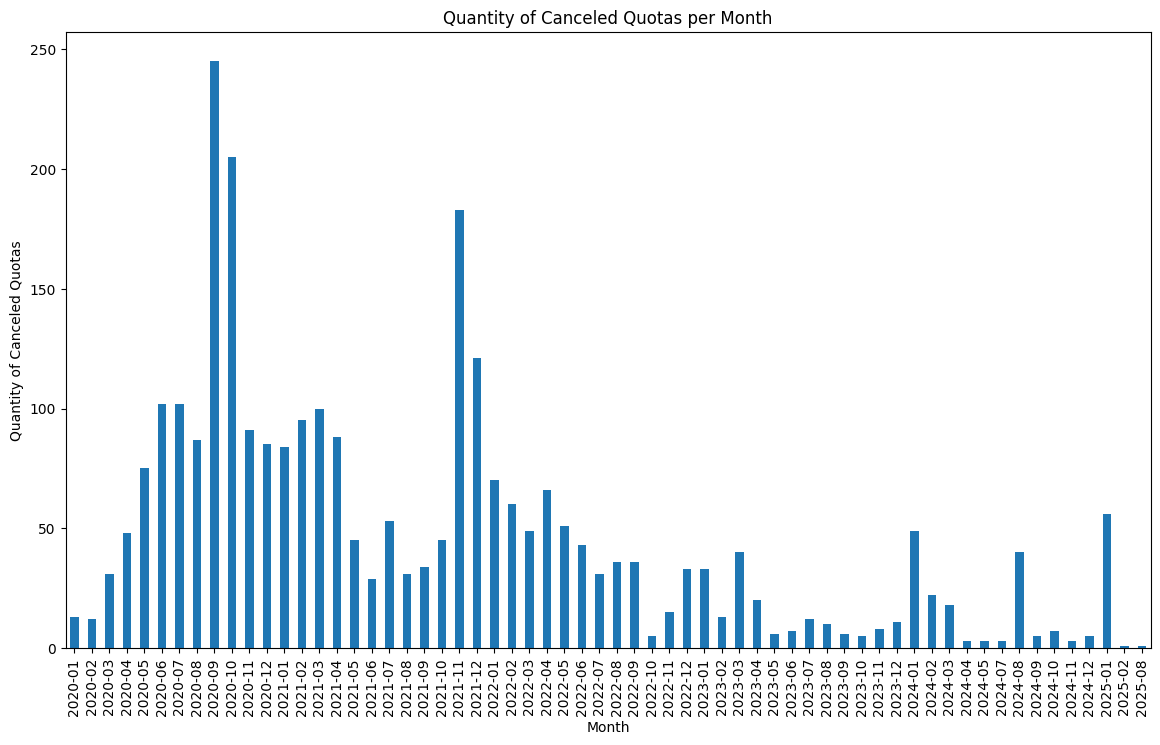

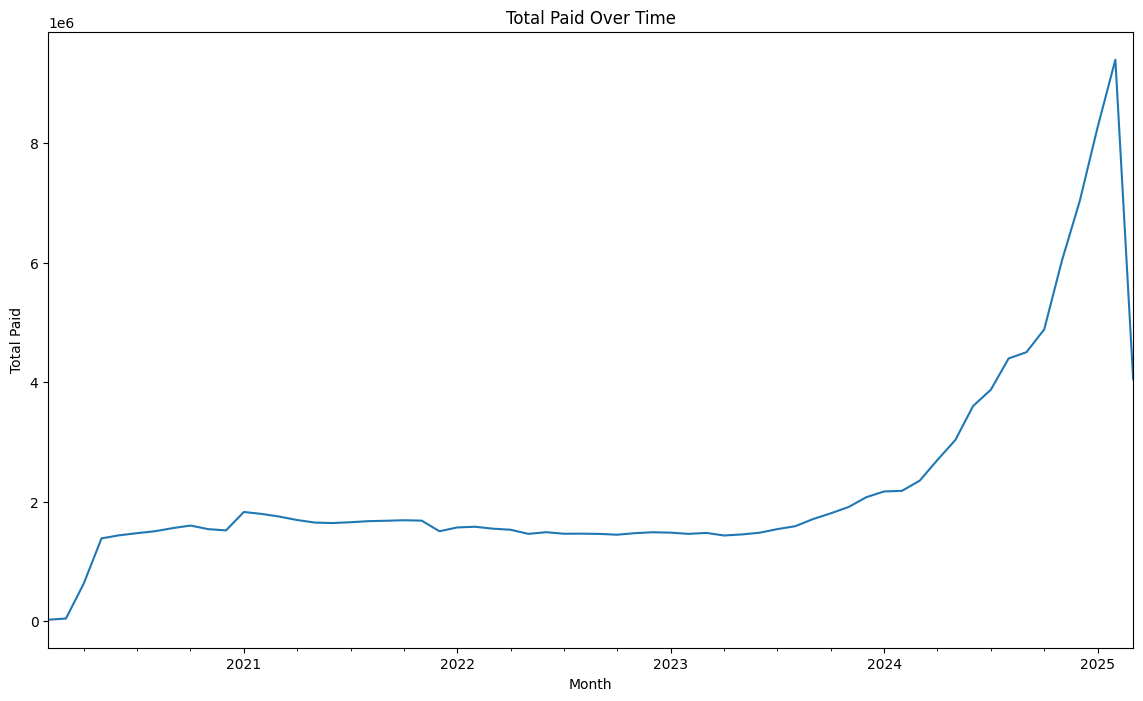

O total pago no grupo todo foi: R$ 138,921,235.50


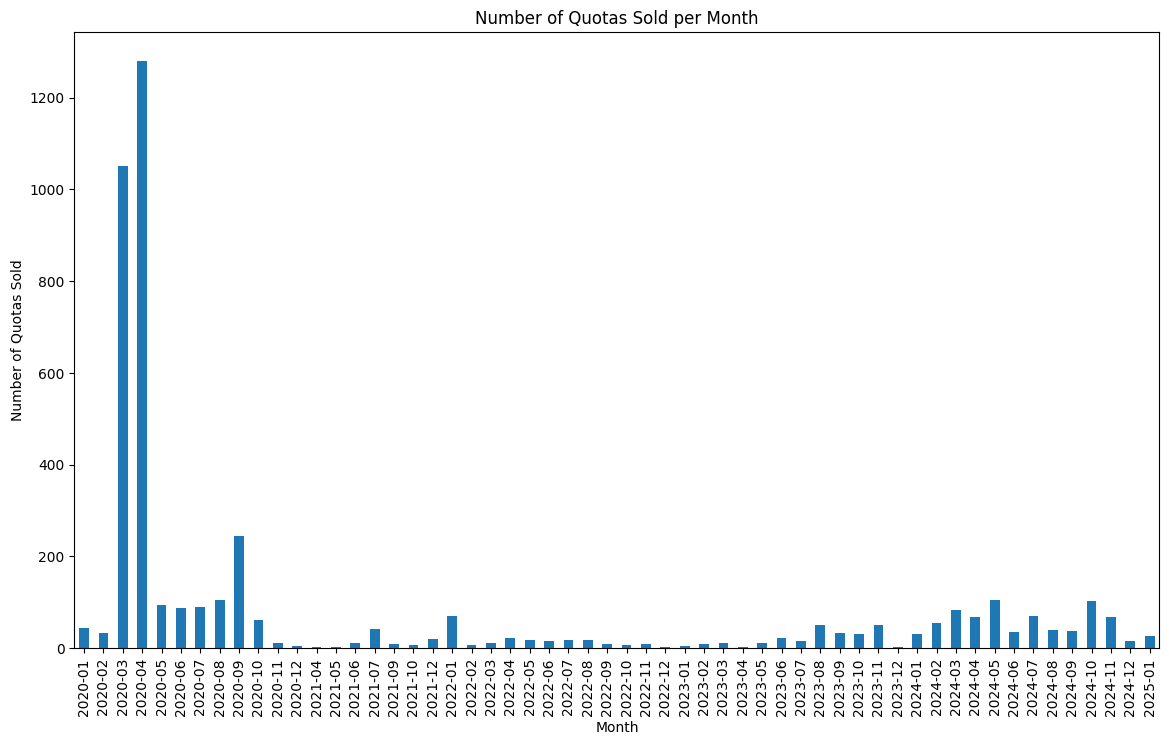

In [155]:
# Visualizations
plt.figure(figsize=(14, 8))

# Total FC, FR, and Adm Taxes
total_fc = df_expanded_consorcio["FC_paid"].sum()
total_fr = df_expanded_consorcio["FR_paid"].sum()
total_tx_adm = df_expanded_consorcio["TX_adm_paid"].sum()

print(f"Total FC: R$ {total_fc:,.2f}")
print(f"Total FR: R$ {total_fr:,.2f}")
print(f"Total Adm Taxes: R$ {total_tx_adm:,.2f}")

# Per Quota Analysis
selected_id = df_expanded_consorcio["id"].unique()[0]  # Select the first quota ID for demonstration
quota_df = df_expanded_consorcio[df_expanded_consorcio["id"] == selected_id]

print(f"### Quota {selected_id} Details")
print(quota_df)

# Plot tx_adm_paid for all quotas
plt.figure(figsize=(14, 8))
df_expanded_consorcio.groupby("month")["TX_adm_paid"].sum().plot()
plt.xlabel("Month")
plt.ylabel("TX Adm Paid")
plt.title("TX Adm Paid Over Time")
plt.show()
print(f"O total da taxa de adm arrecadado no grupo todo foi: R$ {df_expanded_consorcio['TX_adm_paid'].sum():,.2f}")
df_canceled = df_grupo[df_grupo['dt_canc'].notna()]
unique_ids_with_dt_canc = df_canceled['id'].unique()
num_unique_ids_with_dt_canc = len(unique_ids_with_dt_canc)
print(f"Tem {num_unique_ids_with_dt_canc} quotas canceladas no grupo")
print(f"Tem {len(df_grupo['id'].unique())} quotas no grupo")
plt.figure(figsize=(14, 8))
df_canceled['dt_canc'] = pd.to_datetime(df_canceled['dt_canc'])
df_canceled['month'] = df_canceled['dt_canc'].dt.to_period('M')
df_canceled['month'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Month")
plt.ylabel("Quantity of Canceled Quotas")
plt.title("Quantity of Canceled Quotas per Month")
plt.show()

# total pago grupo
df_expanded_consorcio['total_paid'] = df_expanded_consorcio['FC_paid'] + df_expanded_consorcio['TX_adm_monthly'] + df_expanded_consorcio['FR_paid'] + df_expanded_consorcio['seguro_paid']
plt.figure(figsize=(14, 8))
df_expanded_consorcio.groupby('month')['total_paid'].sum().plot()
plt.xlabel("Month")
plt.ylabel("Total Paid")
plt.title("Total Paid Over Time")
plt.show()
print(f"O total pago no grupo todo foi: R$ {df_expanded_consorcio['total_paid'].sum():,.2f}")

# data de entrada de quotas
# Count the number of quotas sold by month
df_grupo['dt_venda'] = pd.to_datetime(df_grupo['dt_venda'])
df_grupo['month_sold'] = df_grupo['dt_venda'].dt.to_period('M')
quotas_sold_by_month = df_grupo['month_sold'].value_counts().sort_index()

# Plot the number of quotas sold by month
plt.figure(figsize=(14, 8))
quotas_sold_by_month.plot(kind='bar')
plt.xlabel("Month")
plt.ylabel("Number of Quotas Sold")
plt.title("Number of Quotas Sold per Month")
plt.show()


Total Cost Consórcio: R$ 138,921,235.50
Total Cost Circulana: R$ 90,552,403.62


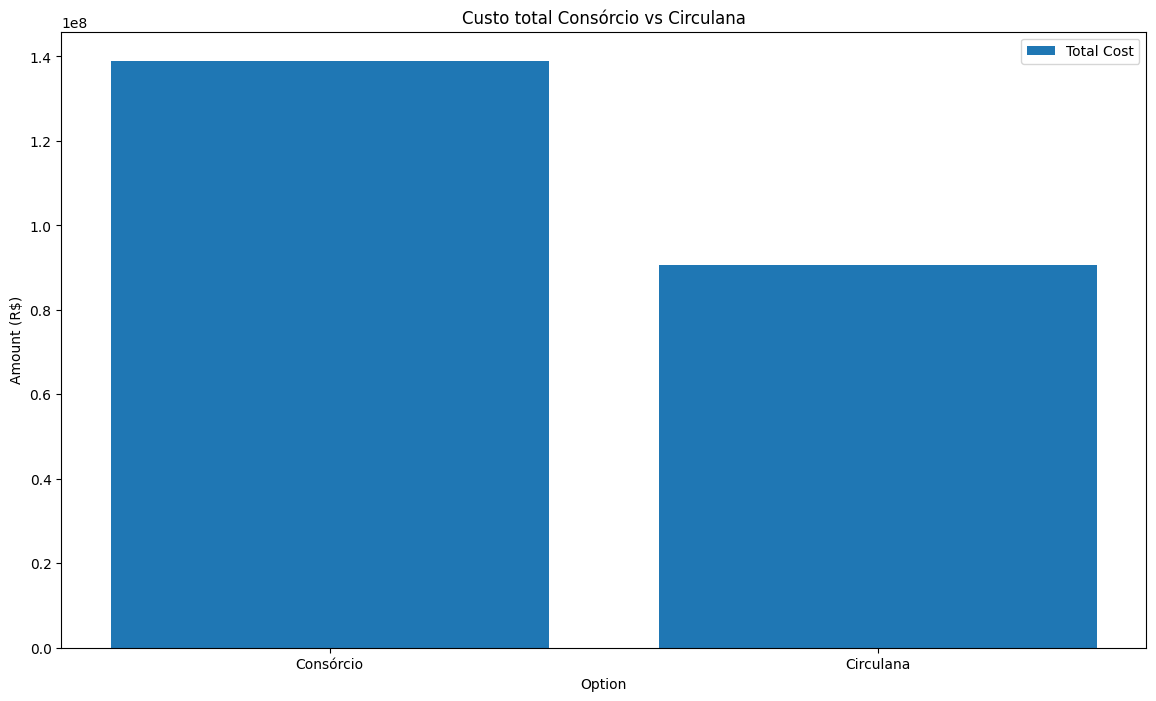

In [156]:
def compare_consorcio_circulana(df_expanded_consorcio, df_expanded_circulana, selected_id=None, tx_adm_filter=None, month_contemplated=None, month_canceled=None):
    # Filter data based on the selected criteria
    if selected_id:
        df_expanded_consorcio = df_expanded_consorcio[df_expanded_consorcio['id'] == selected_id]
        df_expanded_circulana = df_expanded_circulana[df_expanded_circulana['id'] == selected_id]
    
    if tx_adm_filter:
        df_expanded_consorcio = df_expanded_consorcio[df_expanded_consorcio['TX_adm_%'] == tx_adm_filter]
        df_expanded_circulana = df_expanded_circulana[df_expanded_circulana['id'].isin(df_expanded_consorcio['id'])]
    
    if month_contemplated:
        df_expanded_consorcio = df_expanded_consorcio[df_expanded_consorcio['month'] == month_contemplated]
        df_expanded_circulana = df_expanded_circulana[df_expanded_circulana['id'].isin(df_expanded_consorcio['id'])]
    
    if month_canceled:
        df_expanded_consorcio = df_expanded_consorcio[df_expanded_consorcio['month'] == month_canceled]
        df_expanded_circulana = df_expanded_circulana[df_expanded_circulana['id'].isin(df_expanded_consorcio['id'])]
    
    # Calculate total costs and returns
    df_expanded_circulana.shape[0]
    df_expanded_consorcio.shape[0]
    total_cost_consorcio = df_expanded_consorcio['FC_paid'].sum() + df_expanded_consorcio['TX_adm_monthly'].sum() + df_expanded_consorcio['FR_paid'].sum() + df_expanded_consorcio['seguro_paid'].sum()
    total_cost_circulana = df_expanded_circulana['FC_paid'].sum() + df_expanded_circulana['TX_adm_monthly'].sum()
    
    # total_return_consorcio = df_expanded_consorcio['vl_bem']
    # total_return_circulana = df_expanded_circulana['colateral_w_profits'].sum()
    
    # Print comparison results
    print(f"Total Cost Consórcio: R$ {total_cost_consorcio:,.2f}")
    print(f"Total Cost Circulana: R$ {total_cost_circulana:,.2f}")
    # print(f"Total Return Consórcio: R$ {total_return_consorcio:,.2f}")
    # print(f"Total Return Circulana: R$ {total_return_circulana:,.2f}")
    
    # Plot comparison
    plt.figure(figsize=(14, 8))
    plt.bar(['Consórcio', 'Circulana'], [total_cost_consorcio, total_cost_circulana], label='Total Cost')
    #plt.bar(['Consórcio', 'Circulana'], [total_return_consorcio, total_return_circulana], label='Total Return', alpha=0.5)
    plt.xlabel('Option')
    plt.ylabel('Amount (R$)')
    plt.title('Custo total Consórcio vs Circulana')
    plt.legend()
    plt.show()

# Compare for a specific month of contemplation
compare_consorcio_circulana(df_expanded_consorcio, df_expanded_circulana)

# Compare for a specific month of cancellation
#compare_consorcio_circulana(df_expanded_consorcio, df_expanded_circulana, month_canceled=pd.Timestamp('2023-06-01'))

df_expanded_consorcio

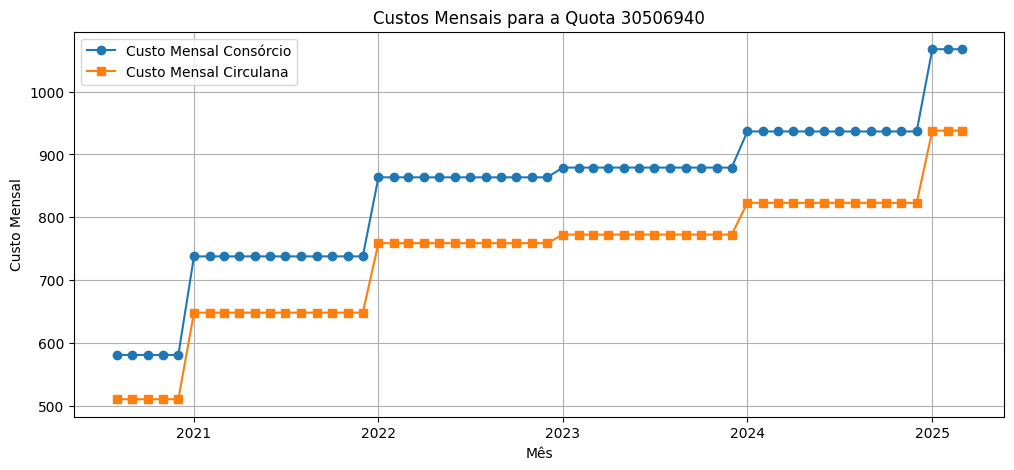

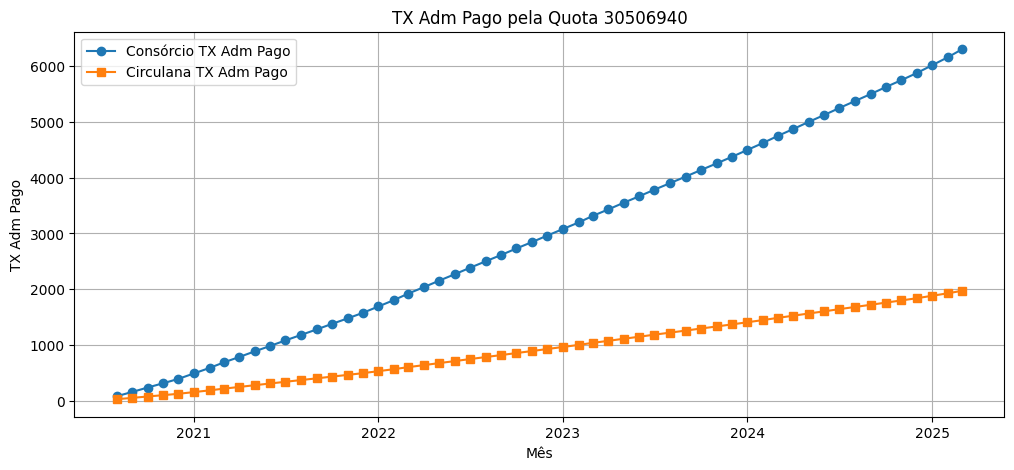

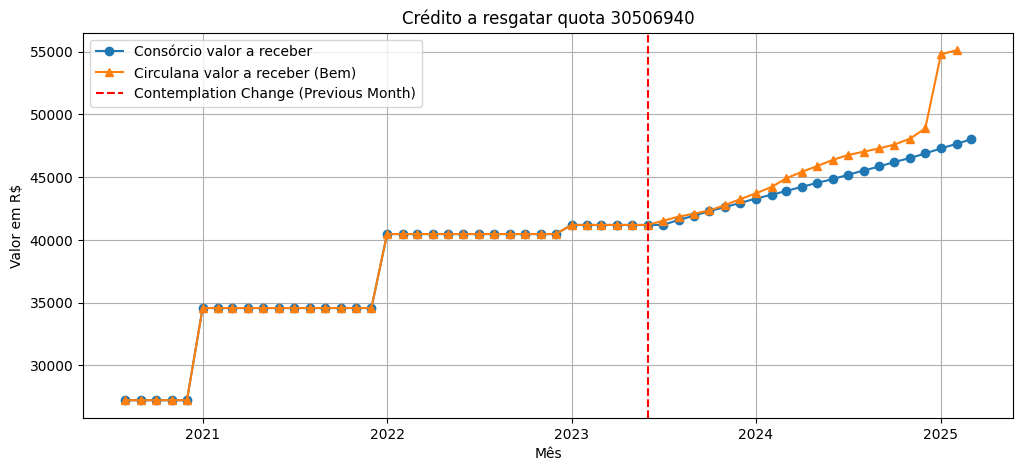

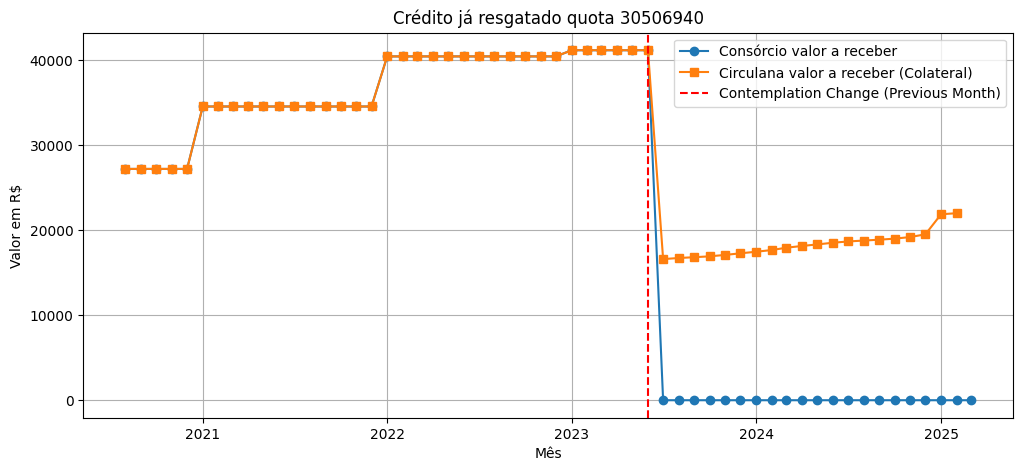

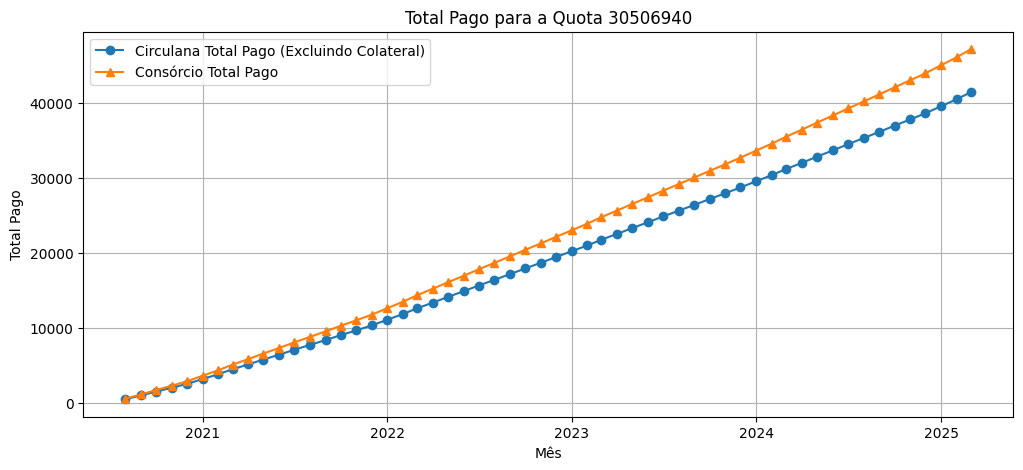

TypeError: float() argument must be a string or a real number, not 'Period'

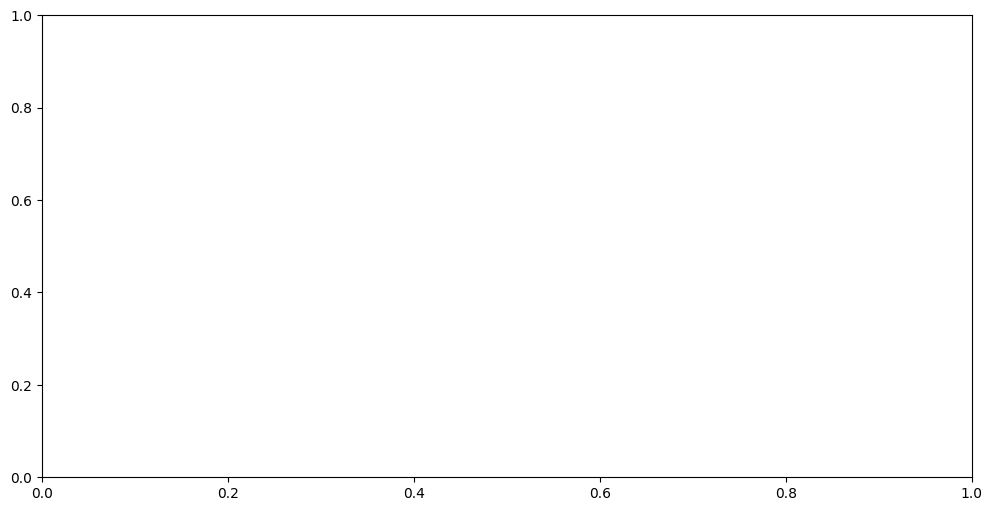

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_quota_comparison(df_consorcio, df_circulana, quota_id):
    """
    Plots the costs and amounts received for the selected quota over time.

    Parameters:
    df_consorcio (pd.DataFrame): DataFrame containing Consórcio data.
    df_circulana (pd.DataFrame): DataFrame containing Circulana data.
    quota_id (int or str): The quota ID to filter the data.
    """
    # Filter and make copies of the data
    consorcio_q = df_consorcio[df_consorcio["id"] == quota_id].copy()
    circulana_q = df_circulana[df_circulana["id"] == quota_id].copy()

    if consorcio_q.empty or circulana_q.empty:
        raise ValueError("Quota ID not found in one of the datasets.")

    # Calculate monthly costs
    consorcio_q.loc[:, "monthly_cost"] = (
        consorcio_q["FC_paid"] + consorcio_q["TX_adm_monthly"] + 
        consorcio_q["FR_paid_monthly"] + consorcio_q["seguro_paid"]
    )
    circulana_q.loc[:, "monthly_cost"] = circulana_q["FC_paid"] + circulana_q["TX_adm_monthly"]
    

    # Calculate amount received
    consorcio_q.loc[:, "amount_received"] = consorcio_q.apply(
        lambda row: row["vl_bem"] if not row["contemplated"] else row["consorcio_w_profits"], axis=1
    )
    #consorcio_q.loc[:, "amount_received"] = consorcio_q["vl_bem"]
    circulana_q.loc[:, "amount_received_colateral"] = circulana_q.apply(
        lambda row: (row["bem_contemplacao_dolar_colateral"] + row["profits_colateral"]) if row["contemplated"] 
                    else (row["vl_bem"] + row["profits_colateral"]),
        axis=1
    )

    circulana_q.loc[:, "amount_received_bem"] = circulana_q.apply(
        lambda row: (row["bem_contemplacao_dolar"] + row["profits_bem"]) if row["contemplated"] 
                    else (row["vl_bem"] + row["profits_bem"]),
        axis=1
    )

    # Calculate total amount paid (with and without collateral)
    circulana_q.loc[:, "total_paid"] = circulana_q["FC_paid"].cumsum() + circulana_q["TX_adm_monthly"].cumsum()
    circulana_q.loc[:, "total_paid_with_colateral"] = circulana_q["total_paid"] + circulana_q["colateral_initial"]

    consorcio_q.loc[:, "total_paid"] = consorcio_q['monthly_cost'].cumsum()

    # Plot monthly costs
    plt.figure(figsize=(12, 5))
    plt.plot(consorcio_q["month"], consorcio_q["monthly_cost"], label="Custo Mensal Consórcio", marker="o")
    plt.plot(circulana_q["month"], circulana_q["monthly_cost"], label="Custo Mensal Circulana", marker="s")
    plt.xlabel("Mês")
    plt.ylabel("Custo Mensal")
    plt.title(f"Custos Mensais para a Quota {quota_id}")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot tx_adm_paid
    plt.figure(figsize=(12, 5))
    plt.plot(consorcio_q["month"], consorcio_q["TX_adm_paid"], label="Consórcio TX Adm Pago", marker="o")
    plt.plot(circulana_q["month"], circulana_q["TX_adm_paid"], label="Circulana TX Adm Pago", marker="s")
    plt.xlabel("Mês")
    plt.ylabel("TX Adm Pago")
    plt.title(f"TX Adm Pago pela Quota {quota_id}")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot amount received
    plt.figure(figsize=(12, 5))
    plt.plot(consorcio_q["month"], consorcio_q["amount_received"], label="Consórcio valor a receber", marker="o")
    plt.plot(circulana_q["month"], circulana_q["amount_received_bem"], label="Circulana valor a receber (Bem)", marker="^")
    
    # Add a red vertical line at the month the quota stops being contemplated False to True
    contemplation_change_month = circulana_q.loc[circulana_q['contemplated'].diff() == 1, 'month']
    if not contemplation_change_month.empty:
        plt.axvline(x=contemplation_change_month.iloc[0] - pd.DateOffset(months=1), color='red', linestyle='--', label='Contemplation Change (Previous Month)')
    
    plt.xlabel("Mês")
    plt.ylabel("Valor em R$")
    plt.title(f"Crédito a resgatar quota {quota_id}")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot amount received
    plt.figure(figsize=(12, 5))
    consorcio_q_temp = consorcio_q.copy()
    consorcio_q_temp.loc[consorcio_q_temp["contemplated"], "amount_received"] = 0
    plt.plot(consorcio_q_temp["month"], consorcio_q_temp["amount_received"], label="Consórcio valor a receber", marker="o")
    plt.plot(circulana_q["month"], circulana_q["amount_received_colateral"], label="Circulana valor a receber (Colateral)", marker="s")
    
    # Add a red vertical line at the month the quota stops being contemplated False to True
    contemplation_change_month = circulana_q.loc[circulana_q['contemplated'].diff() == 1, 'month']
    if not contemplation_change_month.empty:
        plt.axvline(x=contemplation_change_month.iloc[0] - pd.DateOffset(months=1), color='red', linestyle='--', label='Contemplation Change (Previous Month)')
    
    plt.xlabel("Mês")
    plt.ylabel("Valor em R$")
    plt.title(f"Crédito já resgatado quota {quota_id}")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot total amount paid (with and without collateral)
    plt.figure(figsize=(12, 5))
    plt.plot(circulana_q["month"], circulana_q["total_paid"], label="Circulana Total Pago (Excluindo Colateral)", marker="o")
    plt.plot(consorcio_q["month"], consorcio_q["total_paid"], label="Consórcio Total Pago", marker="^")
    plt.xlabel("Mês")
    plt.ylabel("Total Pago")
    plt.title(f"Total Pago para a Quota {quota_id}")
    plt.legend()
    plt.grid()
    plt.show()
    # consorcio_q.loc[:, "accumulated_monthly_cost"] = consorcio_q["monthly_cost"].cumsum()
    # circulana_q.loc[:, "accumulated_monthly_cost"] = circulana_q["monthly_cost"].cumsum()
    
    # # Calculate total earned money (total_paid - amount_received)
    # consorcio_q["earned_money"] = consorcio_q.apply(
    #     lambda row: row["amount_received"] - row["accumulated_monthly_cost"] if row["contemplated"] else -row["accumulated_monthly_cost"], axis=1
    # )
    # circulana_q["earned_money"] = circulana_q.apply(
    #     lambda row: row["amount_received_bem"] - row["accumulated_monthly_cost"] if row["contemplated"] else -row["accumulated_monthly_cost"], axis=1
    # )

    # # Plot total earned money
    # plt.figure(figsize=(12, 5))
    # plt.plot(consorcio_q["month"], consorcio_q["earned_money"], label="Consórcio Dinheiro Ganhado", marker="o")
    # plt.plot(circulana_q["month"], circulana_q["earned_money"], label="Circulana Dinheiro Ganhado", marker="^")
    # plt.xlabel("Mês")
    # plt.ylabel("Saldo consórcio circulana")
    # plt.title(f"Saldo consórcio circulana {quota_id}")
    # plt.legend()
    # plt.grid()
    # plt.show()

    # Calculate accumulated monthly cost
    consorcio_q["accumulated_monthly_cost"] = consorcio_q["monthly_cost"].cumsum()
    circulana_q["accumulated_monthly_cost"] = circulana_q["monthly_cost"].cumsum()

    consorcio_q["recebimento"] = consorcio_q.apply(
        lambda row: row["vl_bem"] if row["contemplated"] else 0, axis=1
    )
    circulana_q["recebimento"] = 0
    contemplation_change_month = circulana_q.loc[circulana_q['contemplated'].diff() == 1, 'month']
    if not contemplation_change_month.empty:
        contemplation_change_month = contemplation_change_month.iloc[0]
        circulana_q.loc[circulana_q['month'] == contemplation_change_month, "recebimento"] = circulana_q["amount_received_colateral"]
        for i in range(1, len(circulana_q)):
            if circulana_q.iloc[i]["month"] > contemplation_change_month:
                circulana_q.loc[circulana_q.index[i], "recebimento"] = circulana_q.iloc[i]["amount_received_colateral"] - circulana_q.iloc[i-1]["amount_received_colateral"]
    
    


    # Create a summary dictionary with categories as columns
    summary_data = {
        "Metric": ["Consórcio (R$)", "Circulana (R$)"],
        "TX_adm": [
            consorcio_q["TX_adm_monthly"].sum(),
            circulana_q["TX_adm_monthly"].sum()
        ],
        "FC": [
            consorcio_q["FC_paid"].sum(),
            circulana_q["FC_paid"].sum()
        ],
        "FR": [
            consorcio_q["FR_paid_monthly"].sum(),
            None
        ],
        "Seguro": [
            consorcio_q["seguro_monthly"].sum(),
            None
        ],
        "Valor do crédito corrigido": [
            consorcio_q["vl_bem"].iloc[-1],
            circulana_q["vl_bem"].iloc[-1]
        ],
        "Valor inicial do bem": [
            consorcio_q["vl_bem"].iloc[0],
            circulana_q["vl_bem"].iloc[0]
        ],
        "Rentabilidade de não resgate": [
            consorcio_q["consorcio_w_profits"].iloc[-1] - consorcio_q["vl_bem"].iloc[-1],
            circulana_q["amount_received_bem"].iloc[-2] - circulana_q["vl_bem"].iloc[-1]
        ],
        "Resgate com rentabilidade (circulana)": [
            None,
            circulana_q["amount_received_colateral"].iloc[-2] - circulana_q["vl_bem"].iloc[-1] * 0.4
        ],
        "Total Pago": [
            consorcio_q["total_paid"].iloc[-1],
            circulana_q["total_paid"].iloc[-1]
        ],
        "Total Recebido sem resgate": [
            consorcio_q["amount_received"].iloc[-1],
            circulana_q["amount_received_bem"].iloc[-2]
        ],
        "Total Recebido com resgate": [
            consorcio_q["vl_bem"].iloc[-1],
            circulana_q["amount_received_colateral"].iloc[-2] + circulana_q["vl_bem"].iloc[-1] * 0.6
        ]
    }

    # Convert to DataFrame
    summary_df = pd.DataFrame(summary_data)

    # Display the modified DataFrame
    display(summary_df)

# Chamar a função com os DataFrames corrigidos
plot_quota_comparison(df_expanded_consorcio, df_expanded_circulana, quota_id=30506940)

In [158]:
def aplication_cdi(amount, date_month):
    """
    Calculates the return based on the CDI for the month of the given date.
    If the exact month is not available, uses the most recent month before the given date.

    Parameters:
    amount (float): The initial investment value.
    date_month (np.datetime64): The date to determine the month and year for CDI calculation.

    Returns:
    float: The calculated return based on the CDI for the month.
    """
    df_cdi = DataFrameLoader.load_and_preprocess_cdi()
    if not isinstance(date_month, pd.Timestamp):
        date_month = pd.to_datetime(date_month)
        
    # Check for an exact match first
    df_exact = df_cdi[df_cdi['date_month'] == date_month]
    if not df_exact.empty:
        cdi = float(df_exact['cdi'].iloc[0])
    else:
        # Find the most recent month before the given date
        df_before = df_cdi[df_cdi['date_month'] < date_month]
        if df_before.empty:
            raise ValueError("No CDI data available for the given date or before.")
        
        df_before_sorted = df_before.sort_values('date_month')
        cdi = float(df_before_sorted.iloc[-1]['cdi'])
        
    return amount * (1 + cdi*0.85)

In [159]:
def get_apy_by_month(target_date, df):
    """
    Returns the average APY for the month of the given date if it exists in the dataset.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'DATE' and 'APY' columns.
    target_date (np.datetime64): The date to search for (used to determine the month and year).

    Returns:
    float or None: The average APY value for the month if data exists, otherwise None.
    """
    df["DATE"] = pd.to_datetime(df["DATE"])
    target_year = pd.to_datetime(target_date).year
    target_month = pd.to_datetime(target_date).month

    monthly_data = df[(df["DATE"].dt.year == target_year) & (df["DATE"].dt.month == target_month)]
    return monthly_data["APY"].mean() if not monthly_data.empty else df["APY"].loc[0], monthly_data["GAS_PRICE_MED"].mean()

In [160]:
def calculate_returns(amount, protocol, initial_date):
    df = path_dict_to_df(protocol)
    df["DATE"] = pd.to_datetime(df["DATE"])
    df = df[df["DATE"] >= initial_date]  # Filter data from the initial date onwards
    df["month"] = df["DATE"].dt.to_period("M")
    
    # Calculate the mean APY for each month
    monthly_apy = df.groupby("month")["APY"].mean().reset_index()
    
    # Convert APY to APM
    monthly_apy["APM"] = (1 + monthly_apy["APY"] / 100) ** (1/12) - 1
    
    # Convert monthly APM to cumulative return
    monthly_apy["Cumulative Return"] = (1 + monthly_apy["APM"]).cumprod() * amount
    
    return monthly_apy[["month", "Cumulative Return"]]


In [161]:
dict_path = {
    'aave': 'apys_aave_v2_USDC.csv',
    'compound': 'apys_compound_USDC.csv',
    'uniswap': 'apys_uniswap_v3-USDC-USDT.csv',
    'balancer': 'apys_balancer_v3_USDC.csv',
}

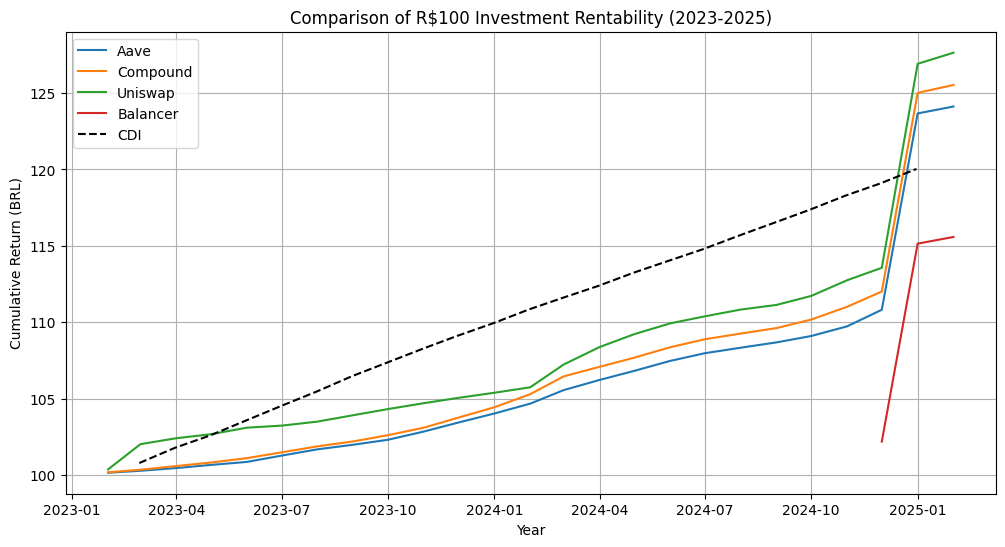

In [162]:
# Initialize investment
initial_investment_brl = 100  # The investment starts in BRL
initial_date = "2023-02-01"
first_available_date = min(path_dict_to_df(list(dict_path.keys())[0])["DATE"])  # Get first available date
initial_investment_usd = convert_currency(first_available_date, initial_investment_brl, to_currency="usd")  # Convert BRL to USD

date_range = pd.date_range(start=initial_date, end="2025-01-01", freq='ME')

# Calculate returns for each protocol (in USD)
returns = {protocol: calculate_returns(initial_investment_usd, protocol, initial_date) for protocol in dict_path.keys()}

for protocol, df in returns.items():
    df["month"] = df["month"].astype(str)  
    df["month"] = pd.to_datetime(df["month"])  

    # Convert cumulative return back to BRL for plotting
    df["Cumulative Return BRL"] = df.apply(lambda row: convert_currency(row["month"], row["Cumulative Return"], to_currency="brl"), axis=1)

# Calculate CDI return over time (in BRL)
cdi_values = []
current_investment = initial_investment_brl
for date in date_range:
    current_investment = aplication_cdi(current_investment, date)
    cdi_values.append(current_investment)

# Plot results
plt.figure(figsize=(12, 6))
for protocol, df in returns.items():
    plt.plot(df["month"], df["Cumulative Return BRL"], label=protocol.capitalize())

plt.plot(date_range, cdi_values, label="CDI", linestyle="dashed", color="black")
plt.xlabel("Year")
plt.ylabel("Cumulative Return (BRL)")
plt.title("Comparison of R$100 Investment Rentability (2023-2025)")
plt.legend()
plt.grid(True)
plt.show()


In [64]:
6.20/5.44

1.1397058823529411

In [69]:
12/17

0.7058823529411765